### Imports

In [1]:
import numpy as np
import tensorflow as tf
import os
import requests
import matplotlib.pyplot as plt

### Data Loading

In [2]:
PATH = 'New Plant Diseases Dataset'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'valid')

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           image_size=IMG_SIZE)

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [3]:
class_names = train_dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

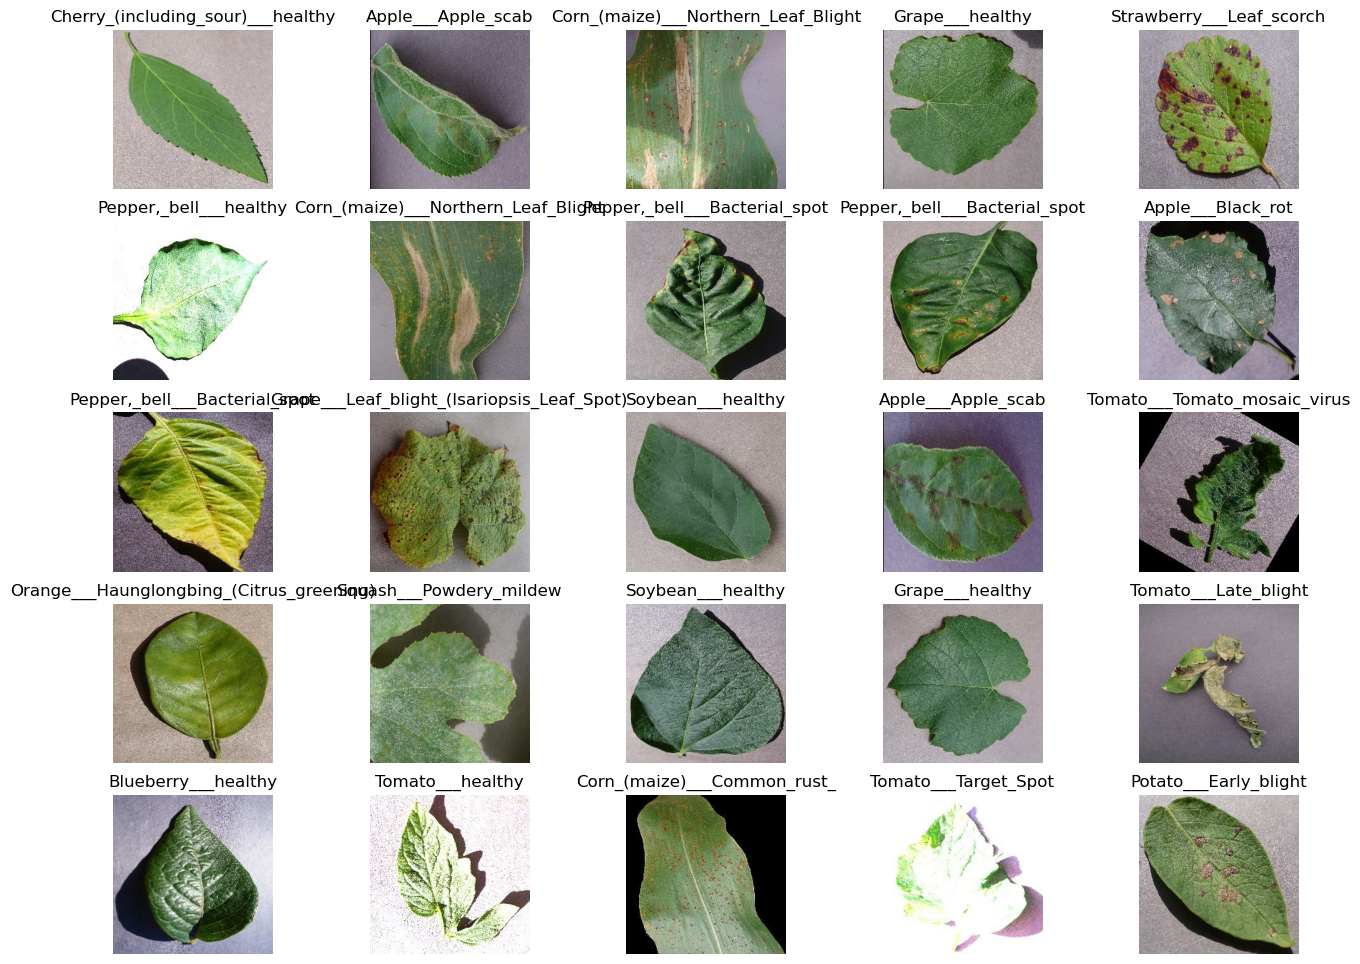

In [4]:
plt.figure(figsize=(16, 12))
for images, labels in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(np.array(images[i]).astype('u1'))
        plt.title(class_names[labels[i]])
        plt.axis(False)

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
tf.data.experimental.cardinality(validation_dataset).numpy(), tf.data.experimental.cardinality(test_dataset).numpy()

(440, 110)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomZoom(0.2, 0.2)
])

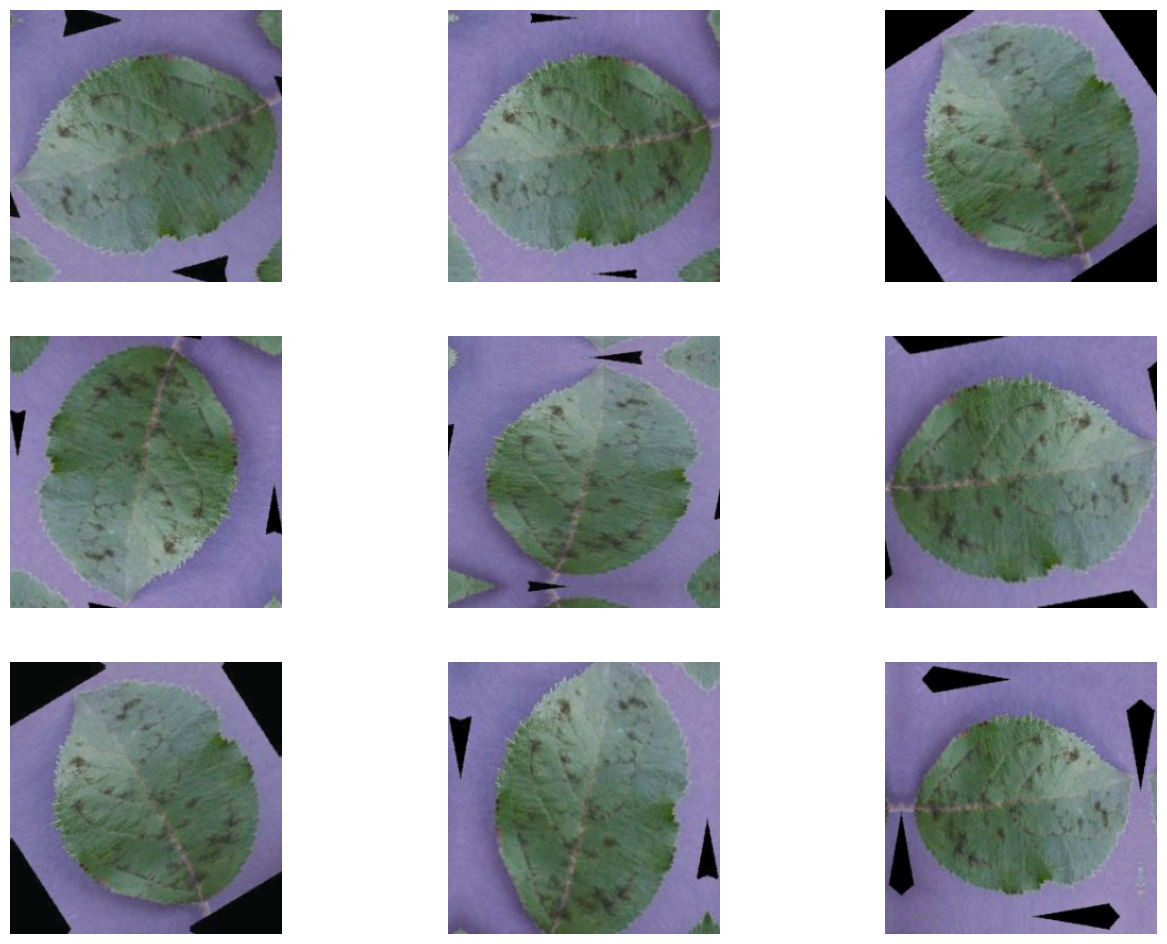

In [9]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(16, 12))
    img = images[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_img = data_augmentation(tf.expand_dims(img, 0))/255
        plt.imshow(augmented_img[0])
        plt.axis(False)

### Model Building

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [11]:
base_model.trainable = False

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [15]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

In [16]:
tf.keras.backend.clear_session

<function keras.backend.clear_session()>

In [17]:
inputs = tf.keras.Input(shape=(IMG_SHAPE))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_lr = 0.01
initial_epochs = 10
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [20]:
history = model.fit(train_dataset, epochs=initial_epochs, steps_per_epoch=150, validation_data=validation_dataset, validation_steps=100)

Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"


150/150 [==============================] - 115s 647ms/step - loss: 1.3042 - accuracy: 0.6810 - val_loss: 0.9395 - val_accuracy: 0.7456
Epoch 2/10
150/150 [==============================] - 65s 433ms/step - loss: 0.7582 - accuracy: 0.8017 - val_loss: 1.0204 - val_accuracy: 0.7522
Epoch 3/10
150/150 [==============================] - 66s 438ms/step - loss: 0.7650 - accuracy: 0.8256 - val_loss: 1.2601 - val_accuracy: 0.7422
Epoch 4/10
150/150 [==============================] - 66s 438ms/step - loss: 0.7976 - accuracy: 0.8319 - val_loss: 0.9891 - val_accuracy: 0.7800
Epoch 5/10
150/150 [==============================] - 65s 435ms/step - loss: 0.7306 - accuracy: 0.8467 - val_loss: 1.0001 - val_accuracy: 0.8000
Epoch 6/10
150/150 [==============================] - 65s 435ms/step - loss: 0.7609 - accuracy: 0.8494 - val_loss: 1.0975 - val_accuracy: 0.7875
Epoch 7/10
150/150 [==============================] - 65s 434ms/step - loss: 0.7516 - accuracy: 0.8533 - val_loss: 1.0024 - val_accuracy: 0.

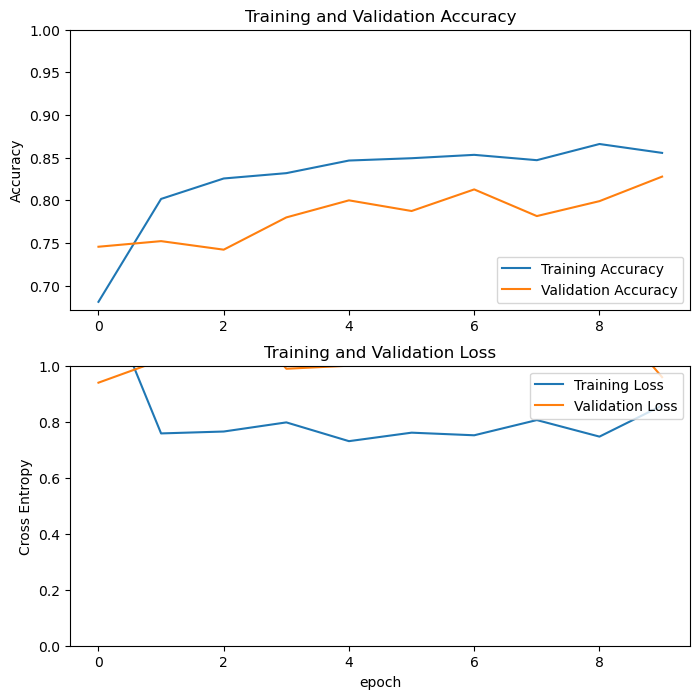

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
base_model.trainable = True

In [23]:
len(base_model.layers)

154

In [24]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [25]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr/100),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [26]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         steps_per_epoch=200,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         validation_steps=100)

Epoch 10/15
200/200 [==============================] - 100s 427ms/step - loss: 1.2096 - accuracy: 0.6931 - val_loss: 1.0751 - val_accuracy: 0.6959
Epoch 11/15
200/200 [==============================] - 93s 468ms/step - loss: 0.6526 - accuracy: 0.8097 - val_loss: 0.6009 - val_accuracy: 0.8075
Epoch 12/15
200/200 [==============================] - 83s 416ms/step - loss: 0.4992 - accuracy: 0.8530 - val_loss: 0.5560 - val_accuracy: 0.8331
Epoch 13/15
200/200 [==============================] - 83s 416ms/step - loss: 0.4695 - accuracy: 0.8592 - val_loss: 0.4852 - val_accuracy: 0.8500
Epoch 14/15
200/200 [==============================] - 93s 465ms/step - loss: 0.4005 - accuracy: 0.8806 - val_loss: 0.4639 - val_accuracy: 0.8603
Epoch 15/15
200/200 [==============================] - 82s 412ms/step - loss: 0.3602 - accuracy: 0.8938 - val_loss: 0.7521 - val_accuracy: 0.7825


In [27]:
model.evaluate(test_dataset)

110/110 [==============================] - 6s 55ms/step - loss: 0.7313 - accuracy: 0.7824


[0.7312960624694824, 0.7823863625526428]

1/1 [==============================] - 0s 26ms/step


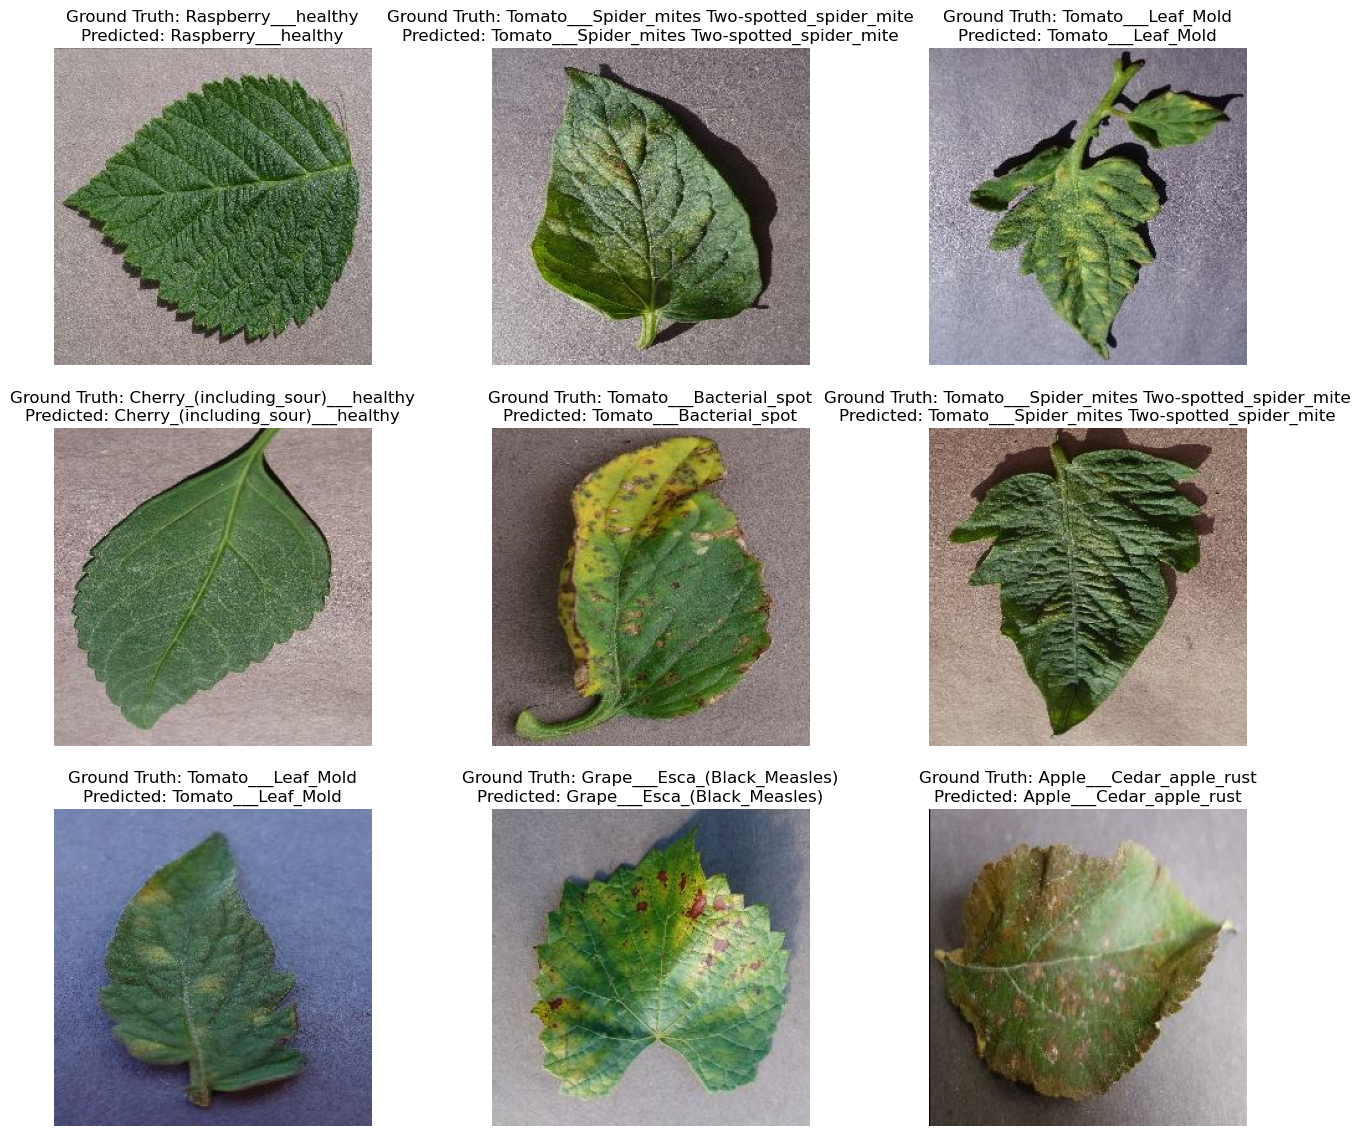

In [92]:
plt.figure(figsize=(16, 14))
for images, labels in test_dataset.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(np.array(images[i]).astype('u1'))
        plt.title('Ground Truth: ' + class_names[labels[i]] + '\n' + 'Predicted: ' + class_names[np.argmax(model.predict(np.expand_dims(images[i], axis=0)), axis=-1)[0]])
        plt.axis(False)

In [28]:
model.save('Plant-Disease-Model.h5')

In [29]:
model.save_weights('plant-disease-model-weights')